In [1]:
from torchvision.datasets import MNIST

dataset = MNIST("./", download=True)
print(dataset[0][1])
display(dataset[0][0])

zeros_and_ones = [i for i, d in enumerate(dataset) if d[1] in (0,1)]
data = dataset.data[zeros_and_ones]
targets = dataset.targets[zeros_and_ones]
images = [dataset[i][0] for i in zeros_and_ones]
print(targets[0])
display(images[0])

5


tensor(0)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


img_encoder = ImageEncoder()


In [3]:
import numpy as np
from qibo import set_backend, Circuit, gates
from qibo.symbols import Z
from qibo.hamiltonians import SymbolicHamiltonian

from qiboml.models.pytorch import QuantumModel
from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation

set_backend("pytorch")

circuit = Circuit(2)
for _ in range(2):
    for q in (0,1):
        circuit.add(gates.RY(q, theta=0.1 * np.pi))
        circuit.add(gates.RZ(q, theta=-0.4 * np.pi))
    circuit.add(gates.CNOT(0,1))
circuit.draw()

observable = SymbolicHamiltonian((1 - Z(0)) / 2, nqubits=2)

q_model = QuantumModel(
    PhaseEncoding(nqubits=2),
    circuit,
    Expectation(nqubits=2, observable=observable)
)

2024-11-07 17:48:50.351865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 17:48:50.364328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 17:48:50.368086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 17:48:50.378328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 17:48:51.075570: W tensorflow/compiler/tf2

q0: ─RY─RZ─o─RY─RZ─o─
q1: ─RY─RZ─X─RY─RZ─X─


tensor([1.], grad_fn=<SigmoidBackward0>)


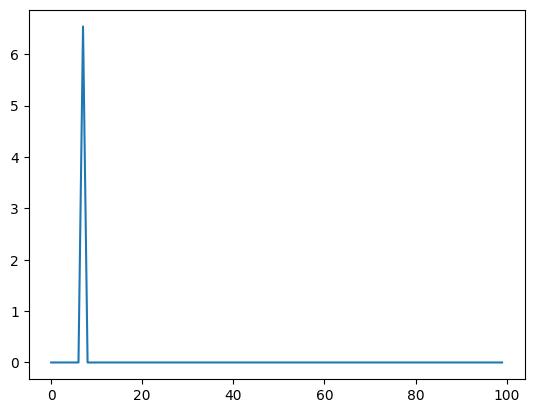

In [8]:
import matplotlib.pyplot as plt
from torch.optim import Adam

optimizer = Adam(img_encoder.parameters())
losses = []
for x, y in zip(data[:100], targets[:100]):
    optimizer.zero_grad()
    out = img_encoder(x.float().unsqueeze(0))
    loss = F.binary_cross_entropy_with_logits(out, y.float().view(1,))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(range(len(losses)), losses)
display(images[-1])
print(F.sigmoid(img_encoder(data[-1].float().unsqueeze(0))))